In [43]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def get_freq(frequency, time_axis):
    return np.cos(2 * np.pi * frequency * time_axis)

In [3]:
fs = 200
n_samples = 10 * fs
print("Number of samples:", n_samples)

Number of samples: 2000


In [124]:
window_length = 256
pool_size = None
tf.reset_default_graph()
input_ph = tf.placeholder(tf.float32, shape=[None, n_samples])
outputs_llc = tf.signal.stft(input_ph, frame_length=window_length, frame_step=window_length//2, name="stft")
outputs_llc = tf.abs(outputs_llc) * 2 / np.sum(np.hanning(window_length))
frequency_axis = np.linspace(0, fs//2, window_length//2 + 1)
# Drop O Hz
outputs_llc = outputs_llc[..., 1:]
frequency_axis = frequency_axis[1:]
# Now we have a spectrogram of shape [batch, times, freq=window_length//2] which is a power of 2
# Now we could pool frequencies
if pool_size is not None:
    outputs_llc = outputs_llc[..., tf.newaxis]  # [batch, times, freq, 1]
    outputs_llc = tf.keras.layers.AvgPool2D(pool_size=(1, pool_size))(outputs_llc)
    outputs_llc = outputs_llc[..., 0]  # [batch, times, freq/pool_size]
    frequency_axis = frequency_axis.reshape((-1, pool_size)).mean(axis=1).flatten()
# Now we remove frequencies above 30Hz
remove_idx = np.where(frequency_axis > 30)[0][0]
outputs_llc = outputs_llc[..., :remove_idx]
frequency_axis = frequency_axis[:remove_idx]

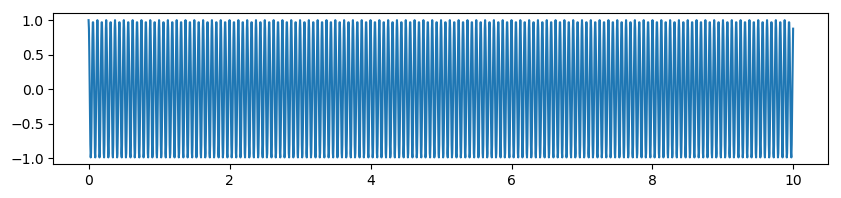

In [114]:
time_axis = np.arange(n_samples) / fs
signal = 1 * get_freq(16, time_axis)
fig, ax = plt.subplots(1, 1, figsize=(10, 2), dpi=100)
ax.plot(time_axis, signal)
plt.show()

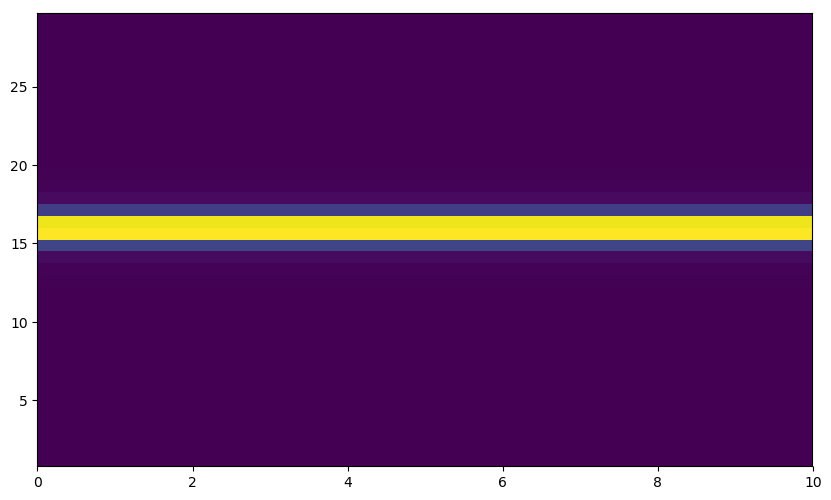

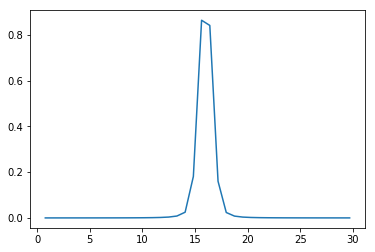

15.625 Hz
Spectrogram shape (14, 38)


In [125]:
with tf.Session() as sess:
    spect = sess.run(outputs_llc, feed_dict={input_ph: signal.reshape(1, -1)})
    spect = spect[0]
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=100)
ax.imshow(
    spect.T, interpolation='none', origin="lower",
    extent=[time_axis[0], time_axis[-1], frequency_axis[0], frequency_axis[-1]], aspect='auto')
plt.show()

plt.plot(frequency_axis, spect[0, :])
plt.show()
max_idx = np.argmax(spect[0, :])
print('%s Hz' % frequency_axis[max_idx])
print('Spectrogram shape', spect.shape)